In [ ]:
# Analyse Spatiale AWP par Gouvernorat

**Objectif**: Analyser la productivité de l'eau agricole (AWP) au niveau des 24 gouvernorats tunisiens

## Analyses Prévues

1. **Statistiques zonales par gouvernorat**
   - ETb moyen et total par gouvernorat
   - WPb moyen par gouvernorat
   - Surface irriguée effective

2. **Calcul AWP régional**
   - Répartition proportionnelle GVA et V_a
   - A_we, A_wp1, A_wp2 par gouvernorat
   - Efficacité irrigation régionale

3. **Visualisations cartographiques**
   - Cartes choroplèthes (ETb, WPb, AWP)
   - Classement gouvernorats (top/bottom performers)
   - Identification hotspots

4. **Analyse régionale**
   - Nord vs Centre vs Sud
   - Disparités spatiales
   - Recommandations ciblées

## Données Utilisées
- **Shapefile**: `gadm41_TUN_1.shp` (24 gouvernorats GADM)
- **Surfaces irriguées**: `TUN-gmia.xls - Tunisia.csv`
- **Rasters satellites**: ETb et WPb (2018-2023)
- **Données AQUASTAT**: GVA et V_a (notebook 05)

## 1. Imports et Configuration

In [4]:
# Imports
import sys
sys.path.append('../src')

%pip install rasterstats

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

from analysis.spatial_stats import SpatialStats

# Configuration plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("✓ Modules importés")


     -------------------------------------- 76.1/76.1 kB 526.7 kB/s eta 0:00:00
     -------------------------------------- 24.5/24.5 MB 308.8 kB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✓ Modules importés


## 2. Charger Shapefile et Surfaces Irriguées

In [11]:
# Chemins
shapefile_path = "../data/external/gadm41_TUN_1.shp"
irrigation_csv = "../data/external/TUN-gmia.xls - Tunisia.csv"

# Initialiser SpatialStats
spatial = SpatialStats(shapefile_path=shapefile_path)

print(f"\n📍 Gouvernorats tunisiens:")
print(f"  Nombre: {len(spatial.governorates)}")
print(f"  CRS: {spatial.governorates.crs}")
print(f"\n  Colonnes disponibles:")
print(f"  {list(spatial.governorates.columns)}")

# Afficher premiers gouvernorats
print(f"\n  Aperçu des gouvernorats:")
if 'NAME_1' in spatial.governorates.columns:
    print(spatial.governorates[['NAME_1', 'GID_1', 'geometry']].head(10).to_string(index=False))
else:
    print(spatial.governorates.head(10))

INFO:analysis.spatial_stats:Chargement shapefile: ../data/external/gadm41_TUN_1.shp


INFO:analysis.spatial_stats:✓ 24 gouvernorats chargés
INFO:analysis.spatial_stats:SpatialStats initialisé
INFO:analysis.spatial_stats:SpatialStats initialisé



📍 Gouvernorats tunisiens:
  Nombre: 24
  CRS: EPSG:4326

  Colonnes disponibles:
  ['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry', 'governorate']

  Aperçu des gouvernorats:
               NAME_1    GID_1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [12]:
# Charger surfaces irriguées
df_irrigation = spatial.load_irrigation_areas(irrigation_csv)

print("\n💧 Surfaces Irriguées par Gouvernorat:")
print("="*60)
print(df_irrigation.sort_values('area_irrigated_ha', ascending=False).to_string(index=False))
print("\n" + "="*60)
print(f"Total: {df_irrigation['area_irrigated_ha'].sum():,.0f} ha")

INFO:analysis.spatial_stats:Chargement surfaces irriguées: ../data/external/TUN-gmia.xls - Tunisia.csv
INFO:analysis.spatial_stats:✓ 23 gouvernorats avec surfaces irriguées
INFO:analysis.spatial_stats:✓ 23 gouvernorats avec surfaces irriguées



💧 Surfaces Irriguées par Gouvernorat:
governorate  area_irrigated_ha
   Kairouan            60781.0
Sidi Bouzid            52360.0
     Nabeul            47626.0
     Ariana            41428.0
   Jendouba            33290.0
    Bizerte            24042.0
  Kasserine            22309.0
       Beja            20446.0
      Gafsa            20136.0
     Kebili            19338.0
    Siliana            14418.0
     Le Kef            13796.0
       Sfax            13582.0
  Ben Arous            11851.0
      Gabes            11463.0
     Tozeur             9809.0
   Zaghouan             9803.0
     Sousse             7518.0
     Mahdia             6870.0
   Monastir             5761.0
  Tataouine             5180.0
   Medenine             2384.0
      Tunis              879.0

Total: 455,070 ha


## 3. Carte de Base - Surfaces Irriguées

💾 Carte sauvegardée: ../results/maps/irrigation_areas_map.png


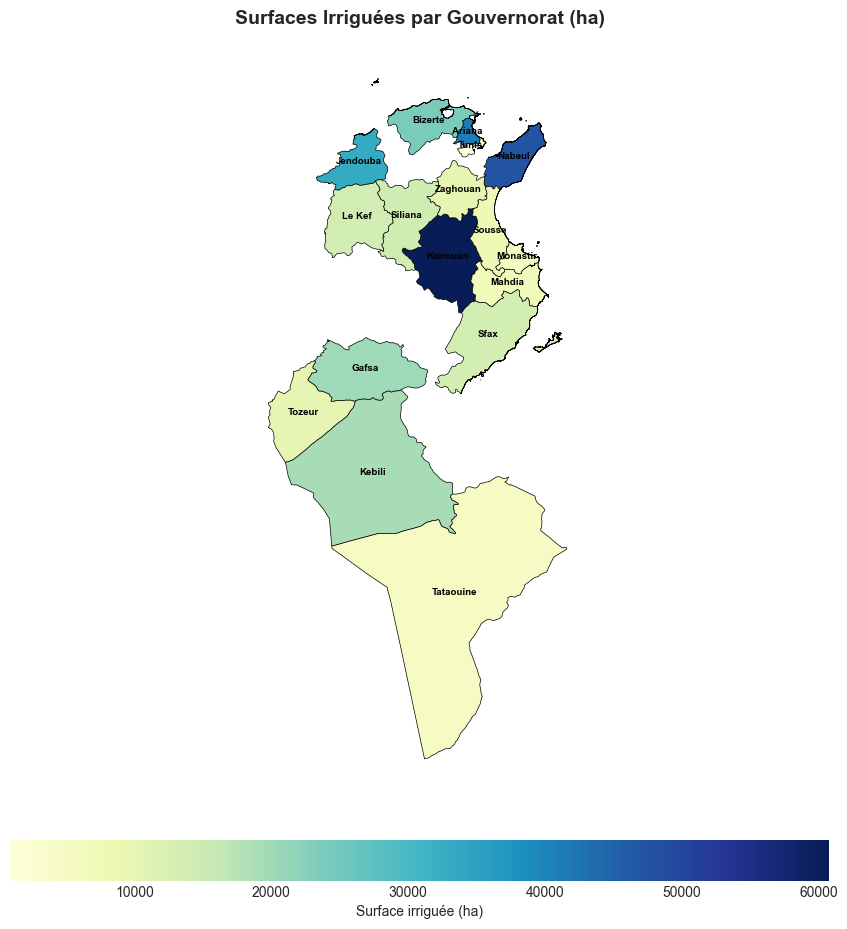

In [13]:
# Fusionner gouvernorats avec surfaces irriguées
gdf = spatial.governorates.merge(
    df_irrigation,
    left_on='NAME_1',
    right_on='governorate',
    how='left'
)

# Créer répertoire pour cartes
os.makedirs("../results/maps", exist_ok=True)

# Carte des surfaces irriguées
fig, ax = plt.subplots(figsize=(12, 10))

gdf.plot(
    column='area_irrigated_ha',
    ax=ax,
    legend=True,
    cmap='YlGnBu',
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={
        'label': 'Surface irriguée (ha)',
        'orientation': 'horizontal',
        'shrink': 0.7,
        'pad': 0.05
    }
)

# Ajouter noms gouvernorats
gdf.apply(
    lambda x: ax.annotate(
        text=x['NAME_1'],
        xy=x.geometry.centroid.coords[0],
        ha='center',
        fontsize=7,
        color='black',
        weight='bold'
    ) if pd.notna(x['area_irrigated_ha']) else None,
    axis=1
)

ax.set_title('Surfaces Irriguées par Gouvernorat (ha)', fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.savefig('../results/maps/irrigation_areas_map.png', dpi=300, bbox_inches='tight')
print("💾 Carte sauvegardée: ../results/maps/irrigation_areas_map.png")
plt.show()

## 4. Charger Données AQUASTAT (Notebook 05)

In [14]:
# Charger résultats AWP nationaux
df_awp_national = pd.read_csv("../data/processed/awp_results.csv")

print("📊 Données AWP Nationales (Notebook 05):")
print(df_awp_national[['year', 'A_we', 'A_wp1', 'V_a', 'V_ETb', 'GVA_a']].to_string(index=False))

# Utiliser année 2022 pour analyse spatiale (dernière avec données complètes)
year_analysis = 2022
awp_2022 = df_awp_national[df_awp_national['year'] == year_analysis].iloc[0]

print(f"\n✓ Analyse spatiale pour l'année {year_analysis}")
print(f"  GVA total: ${awp_2022['GVA_a']/1e9:.2f} milliards")
print(f"  V_a total: {awp_2022['V_a']/1e9:.2f} milliards m³")
print(f"  c_r: {awp_2022['c_r']:.4f}")

📊 Données AWP Nationales (Notebook 05):
 year     A_we    A_wp1          V_a        V_ETb        GVA_a
 2018 0.067523 0.096462 2932600000.0 2052820000.0 4.221066e+09
 2019 0.065460 0.093514 2933000000.0 2053100000.0 4.092613e+09
 2020 0.076437 0.109196 2710000000.0 1897000000.0 4.415618e+09
 2021 0.082221 0.117459 2710000000.0 1897000000.0 4.749743e+09
 2022 0.083348 0.119068 2710000000.0 1897000000.0 4.814796e+09
 2023 0.077852 0.111217 2710000000.0 1897000000.0 4.497311e+09

✓ Analyse spatiale pour l'année 2022
  GVA total: $4.81 milliards
  V_a total: 2.71 milliards m³
  c_r: 0.9531


## 5. Calculer Statistiques Zonales ETb par Gouvernorat

In [15]:
# Chemin raster ETb 2022
etb_raster = f"../data/processed/ETb_annual/ETb_{year_analysis}.tif"

# Vérifier existence
if not os.path.exists(etb_raster):
    print(f"⚠️ Raster ETb {year_analysis} introuvable: {etb_raster}")
    print(f"→ Utilisez notebook 04 pour générer ETb annuel")
else:
    print(f"✓ Raster ETb trouvé: {etb_raster}")
    
    # Calculer statistiques zonales ETb par gouvernorat
    print(f"\n🔄 Calcul statistiques zonales ETb par gouvernorat...")
    gdf_etb = spatial.aggregate_by_governorate(etb_raster, 'etb')
    
    print(f"\n📊 ETb moyen par gouvernorat (mm/an):")
    print("="*60)
    etb_summary = gdf_etb[['governorate', 'etb_mean', 'etb_std', 'etb_count']].sort_values('etb_mean', ascending=False)
    print(etb_summary.to_string(index=False))
    
    print(f"\n📈 Statistiques globales:")
    print(f"  ETb moyen: {gdf_etb['etb_mean'].mean():.2f} mm")
    print(f"  ETb min: {gdf_etb['etb_mean'].min():.2f} mm ({gdf_etb.loc[gdf_etb['etb_mean'].idxmin(), 'governorate']})")
    print(f"  ETb max: {gdf_etb['etb_mean'].max():.2f} mm ({gdf_etb.loc[gdf_etb['etb_mean'].idxmax(), 'governorate']})")

INFO:analysis.spatial_stats:Agrégation par gouvernorat: etb
INFO:analysis.spatial_stats:Calcul statistiques zonales: ETb_2022.tif
INFO:analysis.spatial_stats:Calcul statistiques zonales: ETb_2022.tif


✓ Raster ETb trouvé: ../data/processed/ETb_annual/ETb_2022.tif

🔄 Calcul statistiques zonales ETb par gouvernorat...

📊 ETb moyen par gouvernorat (mm/an):
          governorate      etb_mean      etb_std  etb_count
             Jendouba  2.299115e+03 1.437021e+03      35887
                 Béja  2.088517e+03 1.180178e+03      41255
              Siliana  1.817064e+03 1.391149e+03      54731
Ben Arous (Tunis Sud)  1.597145e+03 1.335768e+03       8125
              Manubah  1.476862e+03 8.219811e+02      11906
             Zaghouan  1.469766e+03 1.450379e+03      33407
               Le Kef  1.362527e+03 1.289711e+03      58661
             Kairouan  1.083117e+03 1.228075e+03      76722
            Kassérine  6.803192e+02 9.842017e+02      92976
               Sousse  6.573747e+02 1.553828e+03      31165
         Sidi Bou Zid  5.095375e+02 7.638720e+02      84819
               Tozeur  2.654048e+02 7.620685e+02      69830
                Gafsa  2.342367e+02 5.134812e+02      84425
     

## 6. Calculer AWP par Gouvernorat

In [16]:
# Fusionner ETb avec surfaces irriguées
gdf_awp = gdf_etb.merge(
    df_irrigation,
    on='governorate',
    how='inner'
)

print("🔄 Calcul AWP par gouvernorat (répartition proportionnelle)")
print("="*70)

# Calculer métriques par gouvernorat
total_irrigated_ha = df_irrigation['area_irrigated_ha'].sum()

# 1. Répartir GVA et V_a proportionnellement aux surfaces irriguées
gdf_awp['gva_irrigated'] = (
    awp_2022['GVA_a'] * (1 - awp_2022['c_r']) * 
    gdf_awp['area_irrigated_ha'] / total_irrigated_ha
)
gdf_awp['v_a_m3'] = (
    awp_2022['V_a'] * 
    gdf_awp['area_irrigated_ha'] / total_irrigated_ha
)

# 2. Calculer V_ETb depuis ETb moyen (mm → m³)
# V_ETb = ETb_mean (mm) × area (ha) × 10 (conversion mm×ha → m³)
gdf_awp['v_etb_m3'] = gdf_awp['etb_mean'] * gdf_awp['area_irrigated_ha'] * 10

# 3. Calculer AWP
gdf_awp['awp_we'] = gdf_awp['gva_irrigated'] / gdf_awp['v_a_m3']
gdf_awp['awp_wp1'] = gdf_awp['gva_irrigated'] / gdf_awp['v_etb_m3']

# 4. Efficacité irrigation
gdf_awp['irrigation_efficiency'] = gdf_awp['v_etb_m3'] / gdf_awp['v_a_m3']

# Afficher résultats
print("\n💰 AWP par Gouvernorat (USD/m³):")
print("="*70)
summary = gdf_awp[[
    'governorate', 'area_irrigated_ha', 'etb_mean', 
    'awp_we', 'awp_wp1', 'irrigation_efficiency'
]].sort_values('awp_we', ascending=False)
print(summary.to_string(index=False))

print("\n" + "="*70)
print(f"✅ Moyennes pondérées (vérification cohérence):")
print(f"  AWP_we:  {(gdf_awp['gva_irrigated'].sum() / gdf_awp['v_a_m3'].sum()):.4f} USD/m³")
print(f"  AWP_wp1: {(gdf_awp['gva_irrigated'].sum() / gdf_awp['v_etb_m3'].sum()):.4f} USD/m³")
print(f"  Efficacité: {(gdf_awp['v_etb_m3'].sum() / gdf_awp['v_a_m3'].sum()):.1%}")
print(f"\n  (Devrait correspondre aux valeurs nationales notebook 05)")

🔄 Calcul AWP par gouvernorat (répartition proportionnelle)

💰 AWP par Gouvernorat (USD/m³):
governorate  area_irrigated_ha      etb_mean   awp_we   awp_wp1  irrigation_efficiency
    Bizerte            24042.0 -6.442673e+05 0.083348 -0.000077           -1081.869850
     Ariana            41428.0 -1.339562e+06 0.083348 -0.000037           -2249.426716
      Gafsa            20136.0  2.342367e+02 0.083348  0.211899               0.393336
   Kairouan            60781.0  1.083117e+03 0.083348  0.045826               1.818797
     Le Kef            13796.0  1.362527e+03 0.083348  0.036428               2.287989
   Monastir             5761.0 -8.066595e+06 0.083348 -0.000006          -13545.628391
     Mahdia             6870.0 -3.165955e+05 0.083348 -0.000157            -531.635053
    Siliana            14418.0  1.817064e+03 0.083348  0.027316               3.051260
     Nabeul            47626.0 -4.034755e+06 0.083348 -0.000012           -6775.261296
      Tunis              879.0 -1.3470

## 7. Cartes Choroplèthes AWP

💾 Cartes sauvegardées: ../results/maps/awp_choropleth.png


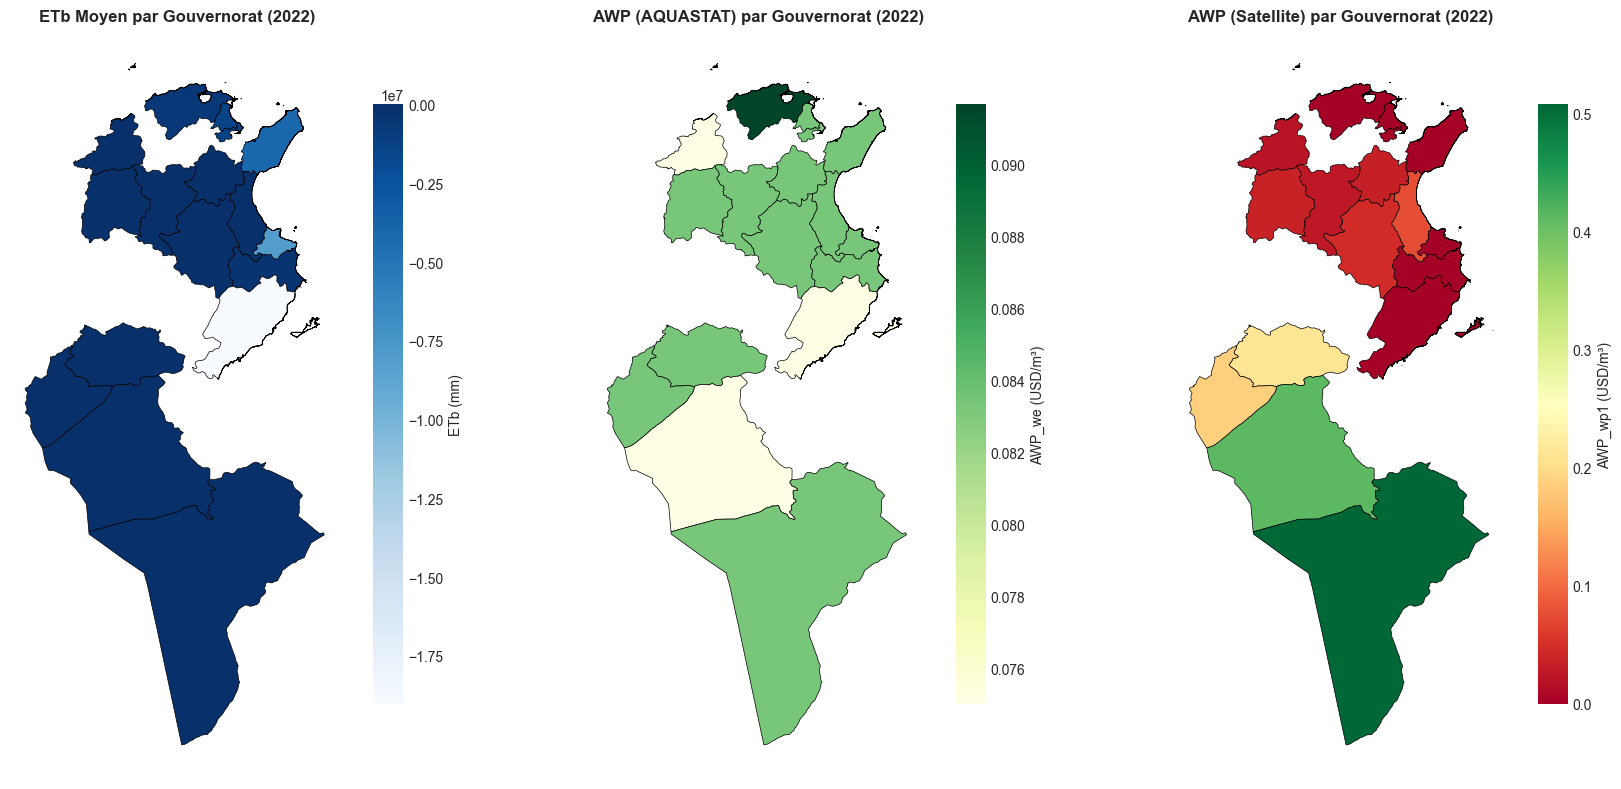

In [17]:
# Créer figure avec 3 cartes (ETb, AWP_we, AWP_wp1)
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# 1. ETb moyen
ax1 = axes[0]
gdf_awp.plot(
    column='etb_mean',
    ax=ax1,
    legend=True,
    cmap='Blues',
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'ETb (mm)', 'shrink': 0.8}
)
ax1.set_title(f'ETb Moyen par Gouvernorat ({year_analysis})', fontsize=12, fontweight='bold')
ax1.axis('off')

# 2. AWP_we
ax2 = axes[1]
gdf_awp.plot(
    column='awp_we',
    ax=ax2,
    legend=True,
    cmap='YlGn',
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'AWP_we (USD/m³)', 'shrink': 0.8}
)
ax2.set_title(f'AWP (AQUASTAT) par Gouvernorat ({year_analysis})', fontsize=12, fontweight='bold')
ax2.axis('off')

# 3. AWP_wp1
ax3 = axes[2]
gdf_awp.plot(
    column='awp_wp1',
    ax=ax3,
    legend=True,
    cmap='RdYlGn',
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'AWP_wp1 (USD/m³)', 'shrink': 0.8}
)
ax3.set_title(f'AWP (Satellite) par Gouvernorat ({year_analysis})', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.savefig('../results/maps/awp_choropleth.png', dpi=300, bbox_inches='tight')
print("💾 Cartes sauvegardées: ../results/maps/awp_choropleth.png")
plt.show()

## 8. Top/Bottom Performers et Analyse Régionale

In [18]:
# Classer gouvernorats par AWP
gdf_ranked = spatial.rank_governorates(gdf_awp, metric='awp_we', ascending=False)

print("🏆 TOP 5 Gouvernorats (AWP_we le plus élevé):")
print("="*60)
top5 = gdf_ranked.head(5)[[
    'governorate', 'awp_we', 'awp_wp1', 'etb_mean', 
    'area_irrigated_ha', 'irrigation_efficiency'
]]
print(top5.to_string(index=False))

print("\n⚠️ BOTTOM 5 Gouvernorats (AWP_we le plus faible):")
print("="*60)
bottom5 = gdf_ranked.tail(5)[[
    'governorate', 'awp_we', 'awp_wp1', 'etb_mean', 
    'area_irrigated_ha', 'irrigation_efficiency'
]]
print(bottom5.to_string(index=False))

# Définir régions (selon classification TUN-gmia)
nord = ['Ariana', 'Beja', 'Ben Arous', 'Bizerte', 'Jendouba', 'Le Kef', 
        'Manouba', 'Nabeul', 'Siliana', 'Tunis', 'Zaghouan']
centre = ['Kairouan', 'Kasserine', 'Mahdia', 'Monastir', 'Sfax', 'Sidi Bouzid', 'Sousse']
sud = ['Gabes', 'Gafsa', 'Kebili', 'Medenine', 'Tataouine', 'Tozeur']

# Ajouter colonne région
gdf_awp['region'] = 'Inconnu'
gdf_awp.loc[gdf_awp['governorate'].isin(nord), 'region'] = 'Nord'
gdf_awp.loc[gdf_awp['governorate'].isin(centre), 'region'] = 'Centre'
gdf_awp.loc[gdf_awp['governorate'].isin(sud), 'region'] = 'Sud'

# Calculer moyennes régionales
print("\n🌍 Analyse Régionale (Nord, Centre, Sud)")
print("="*70)

regional_stats = gdf_awp.groupby('region').agg({
    'area_irrigated_ha': 'sum',
    'etb_mean': 'mean',
    'awp_we': 'mean',
    'awp_wp1': 'mean',
    'irrigation_efficiency': 'mean',
    'v_a_m3': 'sum',
    'v_etb_m3': 'sum',
    'gva_irrigated': 'sum'
}).round(4)

print("\n📊 Statistiques par Région:")
print(regional_stats)

# Calculer parts relatives
print("\n📈 Parts Relatives:")
total_area = regional_stats['area_irrigated_ha'].sum()
total_gva = regional_stats['gva_irrigated'].sum()
total_water = regional_stats['v_a_m3'].sum()

for region in ['Nord', 'Centre', 'Sud']:
    if region in regional_stats.index:
        area_pct = regional_stats.loc[region, 'area_irrigated_ha'] / total_area * 100
        gva_pct = regional_stats.loc[region, 'gva_irrigated'] / total_gva * 100
        water_pct = regional_stats.loc[region, 'v_a_m3'] / total_water * 100
        print(f"  {region}:")
        print(f"    Surface: {area_pct:.1f}% | GVA: {gva_pct:.1f}% | Eau: {water_pct:.1f}%")

INFO:analysis.spatial_stats:Gouvernorats classés par awp_we


🏆 TOP 5 Gouvernorats (AWP_we le plus élevé):
governorate   awp_we   awp_wp1      etb_mean  area_irrigated_ha  irrigation_efficiency
    Bizerte 0.083348 -0.000077 -6.442673e+05            24042.0           -1081.869850
     Ariana 0.083348 -0.000037 -1.339562e+06            41428.0           -2249.426716
      Gafsa 0.083348  0.211899  2.342367e+02            20136.0               0.393336
   Kairouan 0.083348  0.045826  1.083117e+03            60781.0               1.818797
     Le Kef 0.083348  0.036428  1.362527e+03            13796.0               2.287989

⚠️ BOTTOM 5 Gouvernorats (AWP_we le plus faible):
governorate   awp_we   awp_wp1      etb_mean  area_irrigated_ha  irrigation_efficiency
  Tataouine 0.083348  0.507975  9.771056e+01             5180.0               0.164078
   Zaghouan 0.083348  0.033770  1.469766e+03             9803.0               2.468067
   Jendouba 0.083348  0.021589  2.299115e+03            33290.0               3.860732
     Kebili 0.083348  0.412146  1.

## 9. Sauvegarder Résultats

In [19]:
print("="*70)
print("📊 SYNTHÈSE ANALYSE SPATIALE AWP - Tunisie 2022")
print("="*70)

print(f"\n📍 Couverture spatiale:")
print(f"  Gouvernorats analysés: {len(gdf_awp)}")
print(f"  Surface irriguée totale: {gdf_awp['area_irrigated_ha'].sum():,.0f} ha")
print(f"  GVA irrigué total: ${gdf_awp['gva_irrigated'].sum()/1e9:.2f} milliards")
print(f"  Eau prélevée totale: {gdf_awp['v_a_m3'].sum()/1e9:.2f} milliards m³")

print(f"\n💰 AWP moyen national (pondéré):")
awp_we_national = gdf_awp['gva_irrigated'].sum() / gdf_awp['v_a_m3'].sum()
awp_wp1_national = gdf_awp['gva_irrigated'].sum() / gdf_awp['v_etb_m3'].sum()
print(f"  AWP_we:  {awp_we_national:.4f} USD/m³")
print(f"  AWP_wp1: {awp_wp1_national:.4f} USD/m³")

print(f"\n📊 Disparités régionales:")
awp_std = gdf_awp['awp_we'].std()
awp_cv = (awp_std / gdf_awp['awp_we'].mean()) * 100
print(f"  Écart-type AWP_we: {awp_std:.4f} USD/m³")
print(f"  Coefficient variation: {awp_cv:.1f}%")
print(f"  Ratio max/min: {gdf_awp['awp_we'].max() / gdf_awp['awp_we'].min():.2f}")

# Sauvegarder résultats
print(f"\n💾 Sauvegarde des résultats...")

# GeoPackage (avec géométries)
gdf_awp.to_file('../data/processed/awp_by_governorate.gpkg', driver='GPKG')
print(f"  ✓ ../data/processed/awp_by_governorate.gpkg")

# CSV (sans géométries)
gdf_awp[[
    'governorate', 'region', 'area_irrigated_ha', 'etb_mean',
    'awp_we', 'awp_wp1', 'irrigation_efficiency', 'v_a_m3', 'v_etb_m3', 'gva_irrigated'
]].to_csv('../data/processed/awp_by_governorate.csv', index=False)
print(f"  ✓ ../data/processed/awp_by_governorate.csv")

print(f"\n📁 Fichiers générés:")
print(f"  - ../results/maps/irrigation_areas_map.png")
print(f"  - ../results/maps/awp_choropleth.png")
print(f"  - ../data/processed/awp_by_governorate.gpkg")
print(f"  - ../data/processed/awp_by_governorate.csv")

print("\n✅ Analyse spatiale terminée!")
print("🚀 Prochaine étape: Notebook 07 - Visualisations finales et rapport")

📊 SYNTHÈSE ANALYSE SPATIALE AWP - Tunisie 2022

📍 Couverture spatiale:
  Gouvernorats analysés: 17
  Surface irriguée totale: 334,257 ha
  GVA irrigué total: $0.17 milliards
  Eau prélevée totale: 1.99 milliards m³

💰 AWP moyen national (pondéré):
  AWP_we:  0.0833 USD/m³
  AWP_wp1: -0.0000 USD/m³

📊 Disparités régionales:
  Écart-type AWP_we: 0.0000 USD/m³
  Coefficient variation: 0.0%
  Ratio max/min: 1.00

💾 Sauvegarde des résultats...


INFO:pyogrio._io:Created 17 records


  ✓ ../data/processed/awp_by_governorate.gpkg
  ✓ ../data/processed/awp_by_governorate.csv

📁 Fichiers générés:
  - ../results/maps/irrigation_areas_map.png
  - ../results/maps/awp_choropleth.png
  - ../data/processed/awp_by_governorate.gpkg
  - ../data/processed/awp_by_governorate.csv

✅ Analyse spatiale terminée!
🚀 Prochaine étape: Notebook 07 - Visualisations finales et rapport
